1031
4096
4096
4096


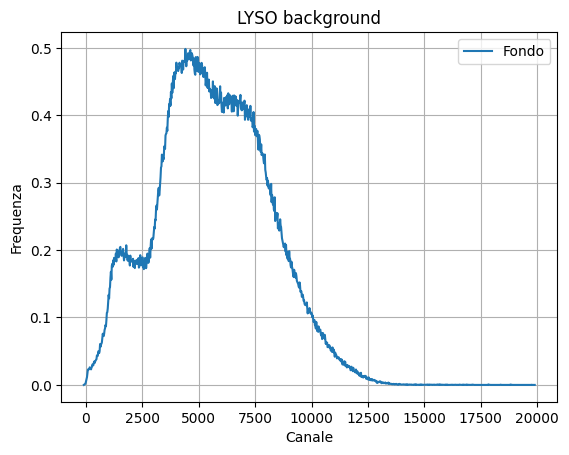

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\LYSO\Fondo LYSO\LYSO-fondo-newgate.CSV', sep=';')
data1 = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\LYSO\Cobalto\SpettroCo_2ndRun_LYSO.csv', sep=' \t', engine='python')

print(len(data['Channel']))
print(len(data1['Channel']))

channel_back = np.array(data['Channel']) #taglio i dati per avere lo stesso numero di elementi
counts_back = np.array(data['Counts'])
time_back = 6335 #s
frequency_back = counts_back/time_back

channel_Co = np.array(data1['Channel'])
counts_Co = np.array(data1['Counts'])
time_Co = 300 #s
frequency_Co = counts_Co/time_Co

# devo allungare il fondo con tanti zeri
allungo_x = np.arange(20510, 81800, 20)
allungo_y = np.zeros(len(allungo_x))
channel_back = np.concatenate((channel_back, allungo_x))
frequency_back = np.concatenate((frequency_back, allungo_y))

print(len(channel_back))
print(len(channel_Co))

plt.plot(channel_back[:1000], frequency_back[:1000], label='Fondo')
plt.xlabel('Canale')
plt.ylabel('Frequenza')
plt.title('LYSO background')
plt.legend()
plt.grid()
plt.show()

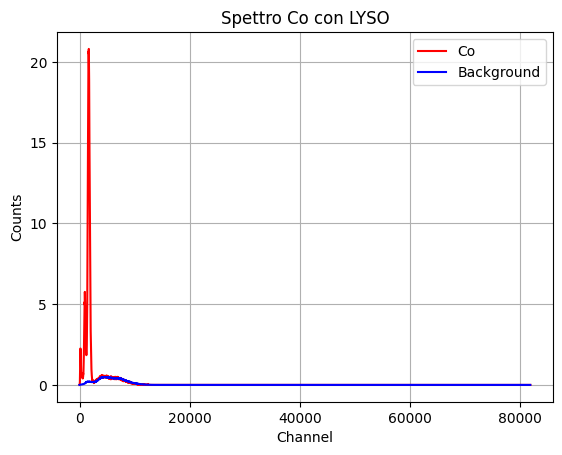

In [2]:
plt.plot(channel_Co, frequency_Co, marker='', linestyle='-', color='red', label='Co')
plt.plot(channel_back, frequency_back, marker='', linestyle='-', color='blue', label='Background')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Spettro Co con LYSO')
plt.legend()
plt.grid()
plt.show()

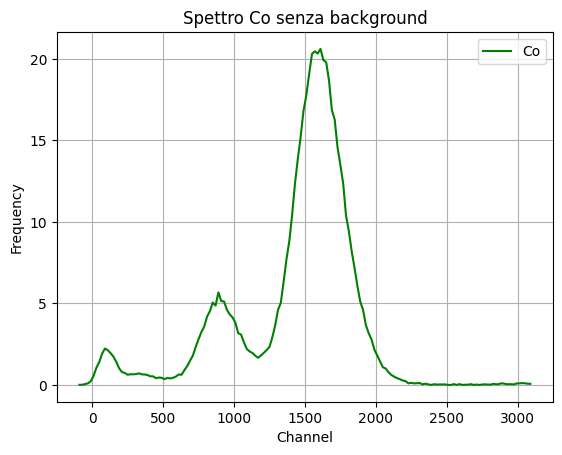

In [3]:
channel = channel_back
frequency = frequency_Co - frequency_back

for i in range(len(frequency)):
    if frequency[i] < 0:
        frequency[i] = 0

plt.plot(channel[:160], frequency[:160], marker='', linestyle='-', color='green', label='Co')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Spettro Co senza background')
plt.grid()

In [4]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2


def repeat_fit(ls, left_bound, right_bound, mu, sigma, A, ampiezza_picco_limite, dis=False, limit_ADC=100):
    '''
    ampiezza picco limite = è la ampiezza dell'intorno di mu in cui è accettabile avere il picco
    '''
    peak_list = []
    error_peak_list = []
    sigma_list = []
    error_sigma_list = []
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC) & (channel < right_bound-delta_ADC)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC) & (channel < right_bound-delta_ADC/2)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC/2) & (channel < right_bound-delta_ADC)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    return np.array(peak_list), np.array(error_peak_list), np.array(sigma_list), np.array(error_sigma_list)

In [5]:
def func(x, mu, sigma, A):
    return A * norm.pdf(x, mu, sigma)

error = np.sqrt(counts_Co)/time_Co

ls = LeastSquares(channel, frequency, error, func)

peak_list14_4, error_peak_list14_4, sigma_list14_4, err_sigma_list14_4 = repeat_fit(ls, 25, 220, 95, 60, 2.5, 30, dis=False, limit_ADC=40)
print(peak_list14_4)
print(error_peak_list14_4)

[107.20273122 107.20273122 101.03598056 101.03598056 107.20273122
 101.28881029 101.28881029  92.29780904  83.33344106 107.20273122
 107.20273122 106.80517538 106.80517538 101.25519938 101.25519938
  99.6107429   99.6107429 ]
[ 1.81008811  1.81008811  4.30817392  4.30817392  1.81008811  4.00309087
  4.00309087 11.12338134 21.89685477  1.81008811  1.81008811  1.84396866
  1.84396866  3.86883227  3.86883227  3.14237543  3.14237543]


In [6]:
peak_list122_1, error_peak_list122_1, sigma_list122_1, err_sigma_list122_1 = repeat_fit(ls, 1200, 2000, 1590, 150, 20, 100, dis=False, limit_ADC=100)
print(peak_list122_1)
print(error_peak_list122_1)

[1596.64276902 1596.64276902 1595.66168587 1595.66168587 1595.01443191
 1595.01443191 1594.62150184 1594.62150184 1594.1178674  1594.1178674
 1584.84728868 1586.1004649  1595.1549884  1594.80195263 1594.80195263
 1593.20314302 1593.16332537 1589.3029889  1589.3029889  1595.59462108]
[ 0.95184574  0.95184574  1.07195062  1.07195062  1.23790554  1.23790554
  1.53647145  1.53647145  1.83822498  1.83822498  3.92516887  4.04714915
  1.05674293  1.25971538  1.25971538  1.49159258  1.50804817  3.14665316
  3.14665316 11.07199509]


In [7]:
def weighted_mean(values, errors):
    mean = np.sum(values/(errors**2))/np.sum(1/(errors**2))
    error_mean = np.sqrt((abs(np.max(values) - np.min(values))/2)**2 + (1/np.sum(1/(errors**2))))
    return mean, error_mean

# first peak at 14.4 keV
mean14_4, error_mean14_4 = weighted_mean(peak_list14_4, error_peak_list14_4)
print(mean14_4, error_mean14_4)

# second peak at 122.1 keV
mean122_1, error_mean122_1 = weighted_mean(peak_list122_1, error_peak_list122_1)
print(mean122_1, error_mean122_1)

print('----------------------------')

print(weighted_mean(sigma_list14_4, err_sigma_list14_4))
print(weighted_mean(sigma_list122_1, err_sigma_list122_1))

105.66583235975234 11.950191050444797
1594.988073891837 5.906150288962014
----------------------------
(66.9979830839159, 16.40565509818746)
(161.07163628792472, 12.472000391279426)
